# 1.- Catalunya's map of Covid-19 incidence by comarca
The idea of this part is to plot the covid cases per comarca for the years 2020-2022, using the dataset "Registre de casos de COVID-19 a Catalunya per municipi i sexe" to obtain the information about Covid and "Divisions administratives" to get the borders of the comarca. 
First of all we read the files:

In [34]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns


#We read the files

covidmap=gpd.read_file(r'/Users/sergig.r/Desktop/comarques/comarques_1M/divisions-administratives-v2r1-comarques-1000000-20250730.shp')
covid=pd.read_csv(r'/Users/sergig.r/Desktop/covidwithaccents.csv')


In [35]:
covid.head() #We display the first rows of the covid dataset

TipusCasData  ComarcaCodi  ComarcaDescripcio  MunicipiCodi  \
0   08/10/2020         21.0            MARESME        8121.0   
1   05/07/2022         23.0            NOGUERA       25240.0   
2   12/06/2020          7.0              BAGES        8191.0   
3   13/01/2022         24.0              OSONA        8037.0   
4   11/06/2022         40.0  VALLÈS OCCIDENTAL        8279.0   

       MunicipiDescripcio  DistricteCodi DistricteDescripcio  SexeCodi  \
0                  MATARÓ            NaN      Not classified       1.0   
1  VALLFOGONA DE BALAGUER            NaN      Not classified       1.0   
2                 SALLENT            NaN      Not classified       1.0   
3             CALLDETENES            NaN      Not classified       1.0   
4                TERRASSA            NaN      Not classified       0.0   

  SexeDescripcio      TipusCasDescripcio  NumCasos  
0         Female  Positiu per Test Ràpid         1  
1         Female             Positiu TAR         2  
2         Female  Positiu per Test Ràpid         1  
3         Female             Positiu PCR         1  
4           Male             Positiu TAR        10

In [36]:
covidmap.head() #We display the first rows of the covidmap dataset

CODICOMAR        NOMCOMAR                CAPCOMAR  AREAC5000  \
0        01        Alt Camp                   Valls   537.8597   
1        02     Alt Empordà                Figueres  1356.9070   
2        03     Alt Penedès  Vilafranca del Penedès   592.5553   
3        04      Alt Urgell         la Seu d'Urgell  1446.6785   
4        05  Alta Ribagorça        el Pont de Suert   427.2234   

                                            geometry  
0  POLYGON ((373020.449 4590188.741, 372482.744 4...  
1  MULTIPOLYGON (((513760.14 4662388.22, 513758.6...  
2  POLYGON ((386593.3 4595896.2, 388616.1 4595870...  
3  MULTIPOLYGON (((360800.1 4649174, 360624.5 464...  
4  POLYGON ((327485.124 4721105.796, 327436.728 4...

## 1.- a) Data Cleaning
First of all, we should say that in the original dataset of Covid, the names of the comarques didn't have accents so we added them by hand. The corrected data set
We see that in order to match both datasets column's name for comarques we have to put the one in covidmap in capital lettes.

In [37]:
covidmap["NOMCOMAR"]=covidmap["NOMCOMAR"].str.upper()

Now, we have to change the name of the same column. Then we will sum to obtain the total covid cases per comarca.

In [38]:
covid=covid.rename(columns={"ComarcaDescripcio": "NOMCOMAR"})

covid_comarca = covid[["NOMCOMAR", "NumCasos"]].groupby("NOMCOMAR")["NumCasos"].sum().reset_index()
covid_comarca.head()
covid_comarca=covid_comarca.dropna()#We drop Nan values

## 1.-b) Merging
We merge the covidmap with the borders and the covid_comarca dataset

In [39]:
covidmap_covid=covidmap.merge(covid_comarca, on="NOMCOMAR", how="left")

## 1.-c) Plotting
In the next box, we plot the map for the total covid cases per comarca.

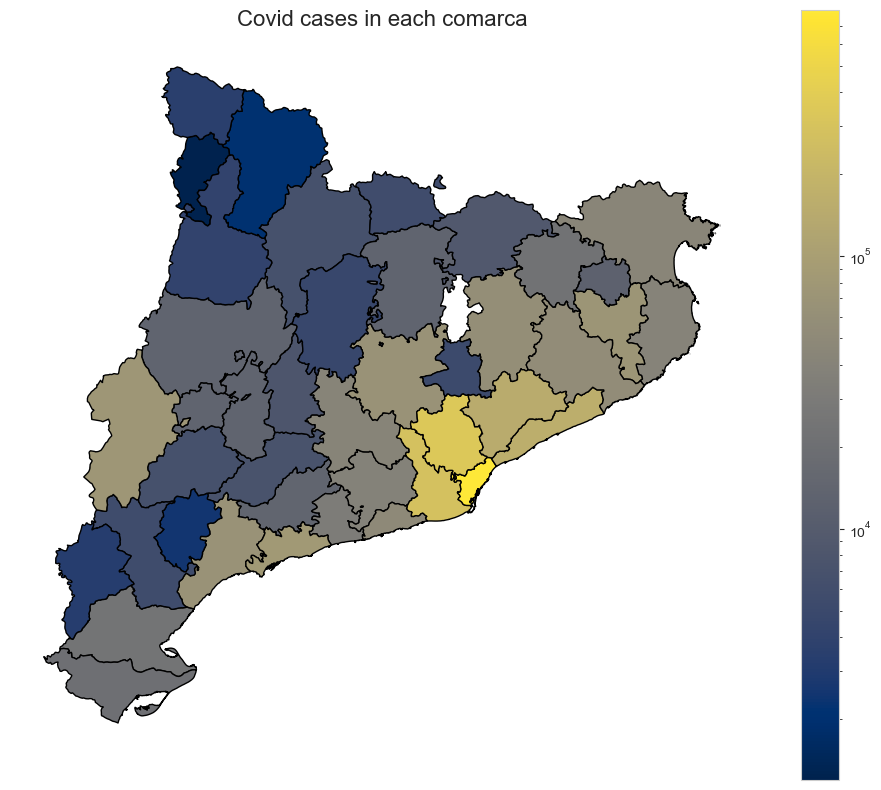

In [40]:
ax=covidmap_covid.plot(
 column="NumCasos",
 cmap="cividis",
 legend=True,
 edgecolor="black",
 figsize=(12,10),
 norm= LogNorm(vmin=covidmap_covid["NumCasos"].min(),
                 vmax=covidmap_covid["NumCasos"].max())
)

ax.set_title("Covid cases in each comarca", fontsize=16)
ax.set_axis_off()
plt.show()

# 2.- Catalunya's map of Covid-19 cases by population by comarca
We can see in the previous map that obviouslyin comarques like the Barcelones were more Covid-19 cases, because there live more people there. We want know to do the same map, but plotting the cases divided by each comarca's population. We will asume that the population doesn't change in each month to plot th density per month and per comarca.
First we will plot the density for the total cases (three years) because it is easier, assuming the population is the same as 2020 for simplicity, and then we will do the general case.

## Total density

In [41]:
poblacio0=pd.read_csv(r'/Users/sergig.r/Desktop/poblacio/poblacio20.csv')

poblacio0["row"]=poblacio0["row"].str.upper()#We put the names in uppercase to be able to merge later
poblacio = poblacio0[poblacio0["col"] == "Població"][["row", "value"]]#generate a column only with the population


In [42]:
poblacio=poblacio.rename(columns={"row": "NOMCOMAR"})#We rename again to be able to merge
densitat=covidmap_covid.merge(poblacio, on="NOMCOMAR", how="left")#We merge

#We calculate the density of covid cases per population
densitat["density"] = densitat["NumCasos"] / densitat["value"]#value is the column for the population of each comarca
densitat.head()

CODICOMAR        NOMCOMAR                CAPCOMAR  AREAC5000  \
0        01        ALT CAMP                   Valls   537.8597   
1        02     ALT EMPORDÀ                Figueres  1356.9070   
2        03     ALT PENEDÈS  Vilafranca del Penedès   592.5553   
3        04      ALT URGELL         la Seu d'Urgell  1446.6785   
4        05  ALTA RIBAGORÇA        el Pont de Suert   427.2234   

                                            geometry  NumCasos     value  \
0  POLYGON ((373020.449 4590188.741, 372482.744 4...   13778.0   44695.0   
1  MULTIPOLYGON (((513760.14 4662388.22, 513758.6...   43064.0  142624.0   
2  POLYGON ((386593.3 4595896.2, 388616.1 4595870...   38196.0  109606.0   
3  MULTIPOLYGON (((360800.1 4649174, 360624.5 464...    6631.0   20231.0   
4  POLYGON ((327485.124 4721105.796, 327436.728 4...    1197.0    3825.0   

    density  
0  0.308267  
1  0.301941  
2  0.348485  
3  0.327764  
4  0.312941

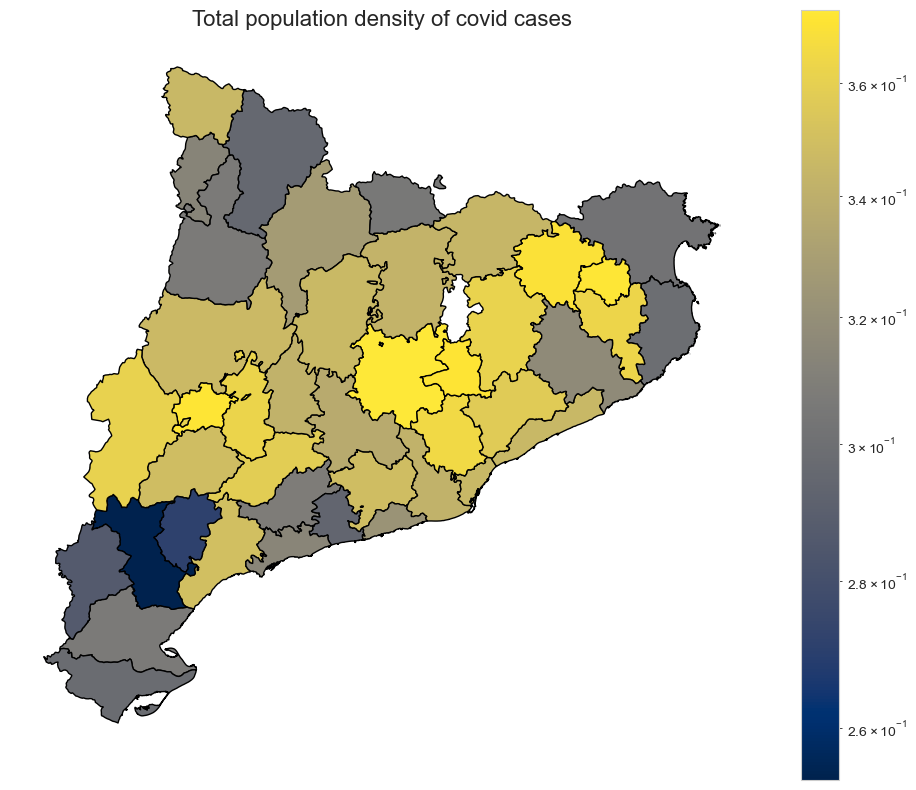

In [43]:
#We plot the density map
ax=densitat.plot(
 column="density",
 cmap="cividis",
 legend=True,
 edgecolor="black",
 figsize=(12,10),
 norm= LogNorm(vmin=densitat["density"].min(),
                 vmax=densitat["density"].max())
)

ax.set_title("Total population density of covid cases", fontsize=16)
ax.set_axis_off()
plt.show()

## Density per month
To start, we create two columns with the month and the year.

In [44]:
#TipusData is the column with the date of each case

covid['TipusCasData'] = pd.to_datetime(covid['TipusCasData'], format='%d/%m/%Y')

#year
covid['year'] = covid['TipusCasData'].dt.year
#month
covid['month'] = covid['TipusCasData'].dt.month

Then, we sum all the cases per each month and comarca, creating a nex list.

In [45]:
covid_month = covid.groupby(['year','month', 'NOMCOMAR'])['NumCasos'].sum().reset_index()

In [46]:


#we remove the NaN values
covid_month=covid_month.dropna()

#we merge with the borders of the comarques
covidmap_covid_month=covidmap.merge(covid_month, on="NOMCOMAR", how="left")

#We read the population files for each year
poblacio20=pd.read_csv(r'/Users/sergig.r/Desktop/poblacio/poblacio20.csv')
poblacio21=pd.read_csv(r'/Users/sergig.r/Desktop/poblacio/poblacio21.csv')
poblacio22=pd.read_csv(r'/Users/sergig.r/Desktop/poblacio/poblacio22.csv')


poblacio20["row"]=poblacio20["row"].str.upper()#Put the names in capital letters
poblacio20=poblacio20[poblacio20["col"] == "Població"][["row", "value"]]#generate a column only with the population
poblacio20=poblacio20.rename(columns={"row": "NOMCOMAR"})#rename the column

poblacio21["row"]=poblacio21["row"].str.upper()#Put the names in capital letters
poblacio21= poblacio21[poblacio21["col"] == "Població"][["row", "value"]]#generate a column only with the population
poblacio21=poblacio21.rename(columns={"row": "NOMCOMAR"})#rename the column

poblacio22["row"]=poblacio22["row"].str.upper()#Put the names in capital letters
poblacio22= poblacio22[poblacio0["col"] == "Població"][["row", "value"]]#generate a column only with the population
poblacio22=poblacio22.rename(columns={"row": "NOMCOMAR"})#rename the column



poblacions = {
    2020: poblacio20,
    2021: poblacio21,
    2022: poblacio22
}


dfs = []  # here we will keep the results

for year in [2020, 2021, 2022]:
    
    # We filter data for the specific year
    df_year = covidmap_covid_month[covidmap_covid_month["year"] == year]
    
    # Merge with population of the corresponding year
    df_merged = df_year.merge(poblacions[year], on="NOMCOMAR", how="left")
    
    # Calculate density (cases / population)
    df_merged["density"] = df_merged["NumCasos"] / df_merged["value"]
    
    dfs.append(df_merged)


densitat_all_filtered = pd.concat(dfs, ignore_index=True)#We concatenate all the dataframes in a single one
#densitat_all.head(43)

Once we have all the maps we can to an animation.

In [ ]:



# Ensure year and month are integers
densitat_all_filtered["year"] = densitat_all_filtered["year"].astype(int)
densitat_all_filtered["month"] = densitat_all_filtered["month"].astype(int)

frames = densitat_all_filtered[["year", "month"]].drop_duplicates()
frames = frames.sort_values(["year", "month"]).reset_index(drop=True)

all_vals = densitat_all_filtered["density"].dropna()

vmin = all_vals.min() if not all_vals.empty else 1e-6
vmax = all_vals.max() if not all_vals.empty else 1.0

# Use logarithmic normalization if values are strictly positive; otherwise use linear
if vmin > 0:
    norm = LogNorm(vmin=vmin, vmax=vmax)
else:
    norm = Normalize(vmin=vmin, vmax=vmax)

cmap = "cividis"   # same colormap as your reference example



fig, ax = plt.subplots(figsize=(10, 10))
fig.subplots_adjust(right=0.88)   # Leave space on the right for the colorbar

# Extra axis for vertical colorbar on the right
cax = fig.add_axes([0.90, 0.15, 0.03, 0.7])


# Compute padded bounds for the map
minx, miny, maxx, maxy = covidmap.total_bounds
pad_frac = 0.02
dx = (maxx - minx) * pad_frac
dy = (maxy - miny) * pad_frac

xlim = (minx - dx, maxx + dx)
ylim = (miny - dy, maxy + dy)



def actualizar(i):
    year = frames.loc[i, "year"]
    month = frames.loc[i, "month"]

    # Select matching year-month data
    gdf = densitat_all_filtered[
        (densitat_all_filtered["year"] == year) &
        (densitat_all_filtered["month"] == month)
    ]

    ax.clear()

    if gdf.empty:
        ax.text(0.5, 0.5, f"No data {year}-{month:02d}", ha='center', va='center')
        ax.axis("off")
        return

    # Draw polygons (GeoPandas returns Axes, NOT a mappable)
    gdf.plot(
        column="density",
        ax=ax,
        cmap=cmap,
        norm=norm,
        legend=False,
        edgecolor="black",
        linewidth=0.4
    )

    # FIX: the real mappable is the last collection added to the Axes
    mappable = ax.collections[-1]

    # Refresh the colorbar without removing the axis
    cax.cla()
    fig.colorbar(mappable, cax=cax, orientation='vertical')

    # Set title and map properties
    ax.set_title(f"Covid density per population — {year}-{month:02d}", fontsize=18)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_aspect("equal", adjustable='box')
    ax.axis("off")


ani = FuncAnimation(fig, actualizar, frames=len(frames), interval=800, repeat=False)

plt.close(fig)
HTML(ani.to_jshtml())



We see that there are peak of incidense in all Catalunya, specially in January of 2022. To see this better we will create a time series of the cases.

# 2.-Covid-19 time series
To explore the total time evoltuion, we will pass by studying also the diference between men and women to the the also the evolution between sexes.


## 2.- a) Covid-19 cases by sex
To explore this new dimention we implement the following lines. First we sum

In [48]:
# sex and add cases
cases_sex= covid.groupby("SexeDescripcio")["NumCasos"].sum()


and we create the plot

/var/folders/80/grlgb68n7h39sbm5_grpw44w0000gn/T/ipykernel_96838/3538568421.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


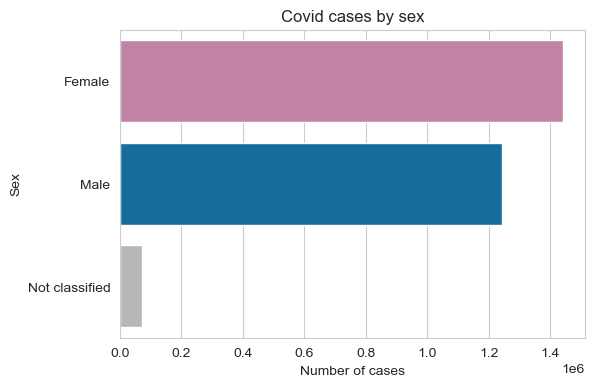

In [49]:
import seaborn as sns
colors = ["#CC79A7", "#0072B2", "#B8B8B8"]
sns.set_style("whitegrid")

plt.figure(figsize=(6,4))
sns.barplot(
    x=cases_sex.values,
    y=cases_sex.index,
    palette=colors
)
plt.title("Covid cases by sex")
plt.xlabel("Number of cases")
plt.ylabel("Sex")
plt.show()

In the previous plot we can see perfectly than women have had more Covid since 2020 to 2022.

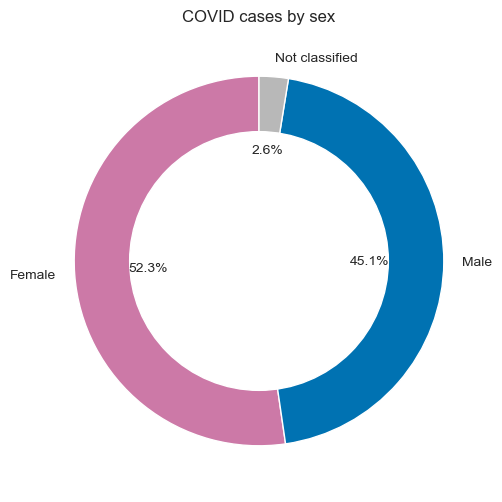

In [50]:
plt.figure(figsize=(6,6))
colors = ["#CC79A7", "#0072B2", "#B8B8B8"]
plt.pie(
    cases_sex,
    labels=cases_sex.index,
    autopct="%1.1f%%",
    startangle=90,
    colors=colors,
    wedgeprops={'edgecolor': 'white'}
)


centro = plt.Circle((0,0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centro)

plt.title("COVID cases by sex")
plt.show()

This graph is more elegant, although it is more difficult to see the difference between sexes.

## 2.- b) Time series by sex
First we create the aggregated dataframe by month.

In [51]:

df_mensual = (
    covid
        .groupby(["year", "month", "SexeDescripcio"])["NumCasos"]
        .sum()
        .reset_index()
)

df_mensual["Time"] = pd.to_datetime(
    df_mensual["year"].astype(str) + "-" + df_mensual["month"].astype(str) + "-01"
)


After this we create a proper data column.

In [52]:
df_mensual["Time"] = pd.to_datetime(
    df_mensual["year"].astype(str) + "-" +
    df_mensual["month"].astype(str) + "-01"
)

Finally we make the plot

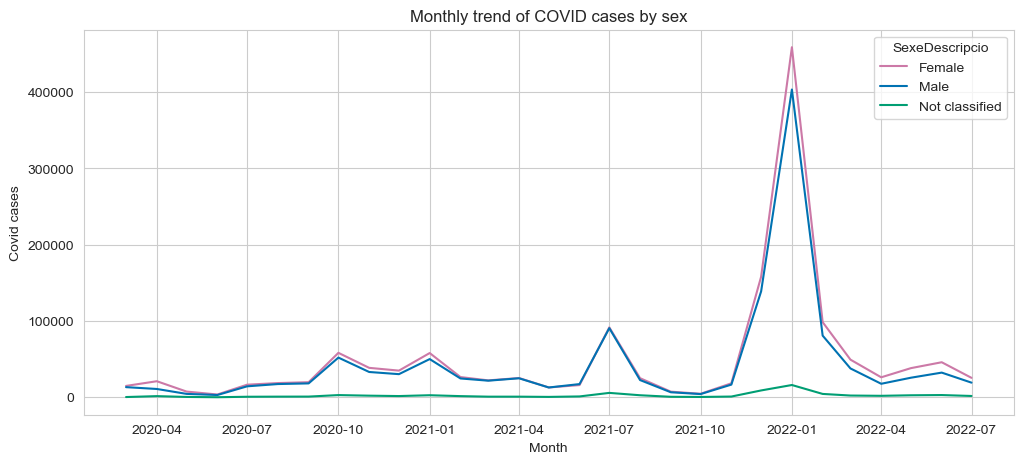

In [53]:
plt.figure(figsize=(12,5))
sns.lineplot(
    data=df_mensual,
    x="Time",
    y="NumCasos",
    hue="SexeDescripcio",
    palette=["#CC79A7", "#0072B2", "#009E73"]  
)

plt.title("Monthly trend of COVID cases by sex")
plt.xlabel("Month")
plt.ylabel("Covid cases")
plt.show()

We can see prefectly the peak in the Covid incidence in January 2022. 

# 3.- Comparing Covid-19 and Mental Health
We want to compare the Covid-19 incidense with the prescriptions of N05 and N06 group.

In [54]:
#superdata.csv is the clean prescription data file
CSV_PATH = "/Users/sergig.r/Desktop/superdata.csv"
df = pd.read_csv(CSV_PATH, thousands=".", decimal=",")

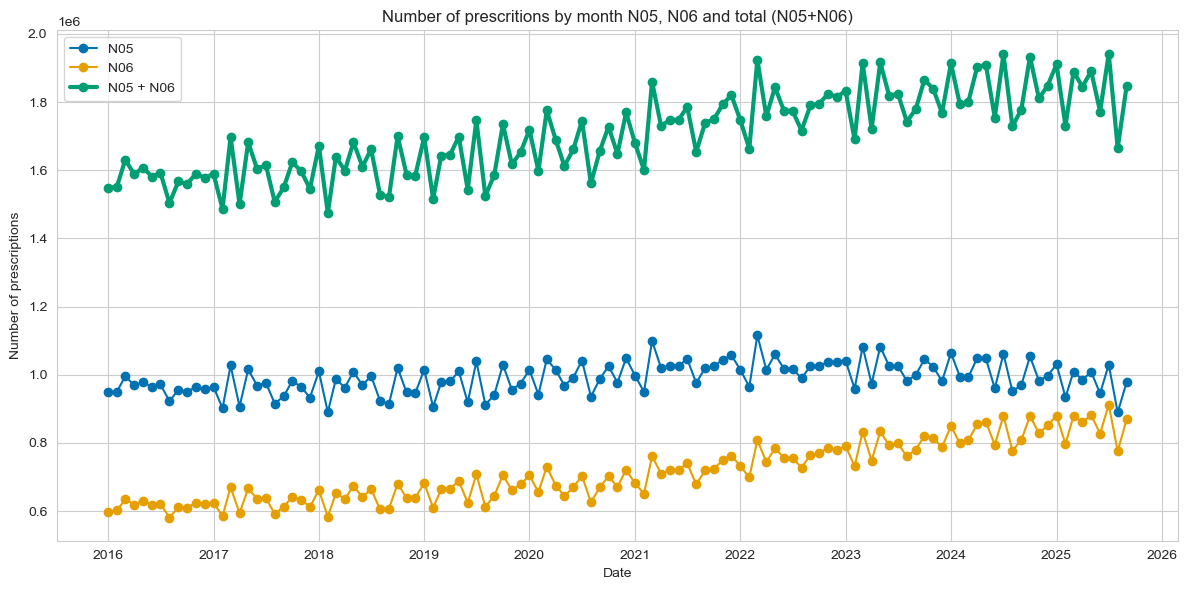

In [55]:
CSV_PATH = "/Users/sergig.r/Desktop/superdata.csv"
df = pd.read_csv(CSV_PATH, thousands=".", decimal=",")

import pandas as pd
import matplotlib.pyplot as plt

# Create date column
df["date"] = pd.to_datetime(df["any"].astype(str) + "-" + df["mes"].astype(str) + "-01")

# Filter N05 and N06
df_filt = df[df["codi del grup ATC nivell 2"].isin(["N05", "N06"])].copy()

# Group by date and ATC group, summing prescriptions

df_grouped = df_filt.groupby(["date", "codi del grup ATC nivell 2"])["nombre de receptes"].sum().reset_index()

plt.figure(figsize=(12, 6))

# Define colors for each group for daltonian-safe palette (Okabe–Ito)
colors = {
    "N05": "#0072B2",   # Azul
    "N06": "#E69F00",   # Naranja
    "TOTAL": "#009E73"  # Verde azulado
}

# Plot N05 and N06 separately
for codigo in ["N05", "N06"]:
    temp = df_grouped[df_grouped["codi del grup ATC nivell 2"] == codigo]
    temp = temp.sort_values("date")
    plt.plot(
        temp["date"], 
        temp["nombre de receptes"], 
        label=codigo, 
        marker='o',
        color=colors[codigo]
    )

# Create the series (N05 + N06)
df_total = df_grouped.groupby("date")["nombre de receptes"].sum().reset_index()
df_total = df_total.sort_values("date")

# Plot total (N05 + N06)
plt.plot(
    df_total["date"], 
    df_total["nombre de receptes"], 
    label="N05 + N06",
    linewidth=3, 
    color=colors["TOTAL"],
    marker='o'
)

plt.title("Number of prescritions by month N05, N06 and total (N05+N06)")
plt.xlabel("Date")
plt.ylabel("Number of prescriptions")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


We can see an increase in the N06 group since 2020. Now we will plot only this group.


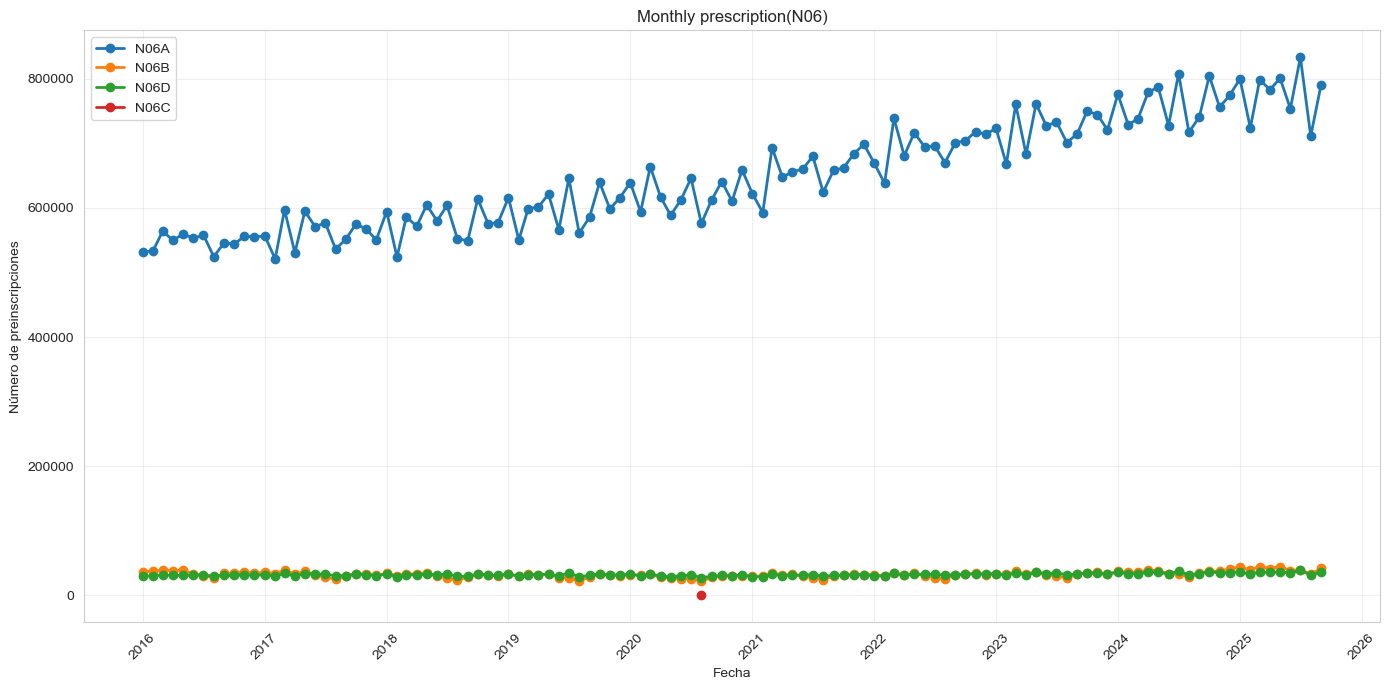

In [56]:
CSV_PATH = "/Users/sergig.r/Desktop/superdata.csv"
df = pd.read_csv(CSV_PATH, thousands=".", decimal=",")

import pandas as pd
import matplotlib.pyplot as plt


df["date"] = pd.to_datetime(df["any"].astype(str) + "-" + df["mes"].astype(str) + "-01")


df_filt = df[df["codi del grup ATC nivell 2"] == "N06"].copy()



df_grouped = df_filt.groupby(["date", "codi del grup ATC nivell 3"])["nombre de receptes"].sum().reset_index()
df_grouped = df_grouped.sort_values("date")

plt.figure(figsize=(14, 7))


for subgrupo in df_grouped["codi del grup ATC nivell 3"].unique():
    temp = df_grouped[df_grouped["codi del grup ATC nivell 3"] == subgrupo]
    plt.plot(temp["date"], temp["nombre de receptes"], 
             label=subgrupo, linewidth=2, marker='o')

plt.title("Monthly prescription(N06)")
plt.xlabel("Fecha")
plt.ylabel("Número de preinscripciones")
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

And now without N06A

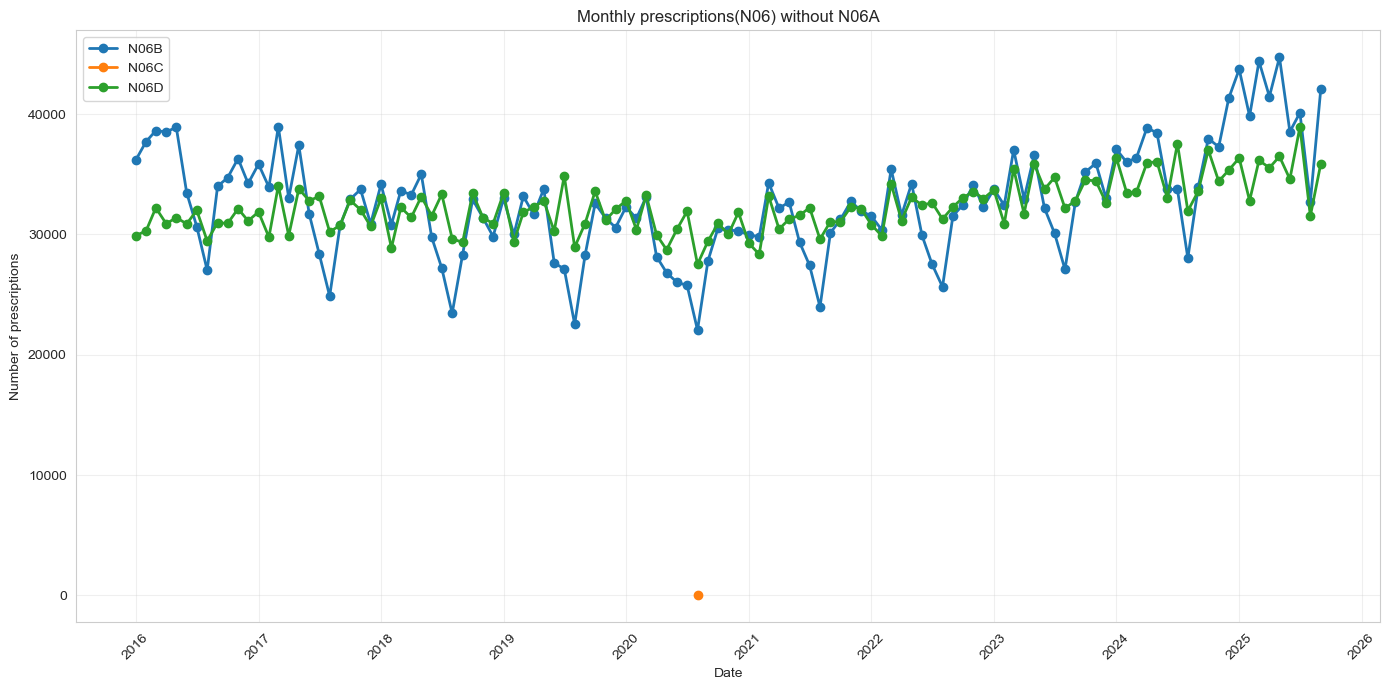

In [57]:
CSV_PATH = "/Users/sergig.r/Desktop/superdata.csv"
df = pd.read_csv(CSV_PATH, thousands=".", decimal=",")

import pandas as pd
import matplotlib.pyplot as plt


df["date"] = pd.to_datetime(df["any"].astype(str) + "-" + df["mes"].astype(str) + "-01")


df_filt = df[df["codi del grup ATC nivell 2"] == "N06"].copy()



df_grouped = df_filt.groupby(["date", "codi del grup ATC nivell 3"])["nombre de receptes"].sum().reset_index()
df_grouped = df_grouped.sort_values("date")

# Filter out N06A
df_grouped = df_grouped[df_grouped["codi del grup ATC nivell 3"] != "N06A"]

plt.figure(figsize=(14, 7))

# Plot each N06 subgroup (excluding N06A)
for subgrupo in sorted(df_grouped["codi del grup ATC nivell 3"].unique()):
    temp = df_grouped[df_grouped["codi del grup ATC nivell 3"] == subgrupo]
    plt.plot(temp["date"], temp["nombre de receptes"], 
             label=subgrupo, linewidth=2, marker='o')

plt.title("Monthly prescriptions(N06) without N06A")
plt.xlabel("Date")
plt.ylabel("Number of prescriptions")
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Results
## Covid
- For the total Covid-19 incidence, since 2020 to 2022, we have seen that as it is expected, Barcelones has had more Covid-19 cases.
- Although, comarques in central Catalunya have had more density(actually not that important result, because we have approximated using only 2020 population to compute the density).
- If we look at the density per month, we have seen that in the peaks of the pandemic we have an homogenous distribution of Covid-19 density, but for other times comarques in the west seemed to have had more Covid.
- We have had several peaks, the most important at January of 2022.
- Women have had more Covid.
## Prescriptions
-In 2020 there was a rise in the number of prescrition of N06 drugsn and it has been more or less increasing until the end of the data.
## General results
- With this information we may think that the rise on the number of prescritions was not due to Covid per se,at least at short term, but for socials effects of it, such as the fear for the illness or the lockdown. If the number of prescription was affected directly by Covid-19 we expect some differences after and before 2022, but this is not the case. We see such a bigger difference in 2020.